In [1]:
from surprise import KNNBaseline, KNNWithMeans, KNNBasic, BaselineOnly, KNNWithZScore
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise import NMF
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
from surprise import SVDpp
from caserec.recommenders.rating_prediction.svdplusplus import SVDPlusPlus
from caserec.recommenders.rating_prediction.gsvdplusplus import GSVDPlusPlus
from caserec.recommenders.rating_prediction.nnmf import NNMF
from caserec.recommenders.rating_prediction.matrixfactorization import MatrixFactorization
from caserec.utils.cross_validation import CrossValidation


import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

%matplotlib inline

In [107]:
dict_for_grades = {'vl-0': 0, 'vl-1': 1, 'vl-2': 2, 'vl-3': 2, 'vl-4': 3, 'vl-5': 3, 'vl-6': 4, 'vl-7': 4, 'vl-8': 4, 'vl-9': 5, 'vl-10': '5a', 'vl-11': '5a+', 'vl-12': '5b', 'vl-13': '5b+', 'vl-14': '5c', 'vl-15': '5c+', 'vl-16': '6a', 'vl-17': '6a+', 'vl-18': '6b', 'vl-19': '6b+', 'vl-20': '6b+', 'vl-21': '6c', 'vl-22': '6c+', 'vl-23': '7a', 'vl-24': '7a+', 'vl-25': '7b', 'vl-26': '7b+', 'vl-27': '7c', 'vl-28': '7c+', 'vl-29': '8a', 'vl-30': '8a+', 'vl-31': '8b', 'vl-32': '8b+', 'vl-33': '8c', 'vl-34': '8c+', 'vl-35': '9a', 'vl-36': '9a+', 'vl-37': '9b', 'vl-38': '9b+', 'vl-39': '9c'}

In [ ]:
import pandas as pd
import psycopg2


conn = psycopg2.connect(
    host='127.0.0.1',
    port=3333,
    user='postgres',
    password='eGu+7V;{9t!LbQ<Y',
    dbname='vertikal_life_14012021'
)
cur_pg = conn.cursor()


Grade proposal prediction:

In [39]:
cur_pg.execute("select * from aux_schema.gym_routes_selected_climbs_v2")
df = pd.DataFrame(cur_pg.fetchall())

In [40]:
df.columns = ['id', 'user_id', 'route_type', 'rating', 'route_id', 'date', 'tries', 'repeats', 'sits', 'recommended', 'user_style', 'user_grade', 'climb_type', 'project', 'protection', 'grade_proposal', 'user_grade_id', 'grade_id', 'user_red_point_id', 'grade_eval_bias', 'route_setter_id', 'height', 'athletic', 'cruxes', 'endurance', 'fingerstrength', 'sloppers', 'technical', 'roof', 'slabs', 'vertikal', 'overhanging', 'user_athletic', 'user_cruxes', 'user_endurance', 'user_fingerstrength', 'user_sloppers', 'user_technical', 'user_climb_type', 'row_number']

In [41]:
df = df[df['user_red_point_id'].notnull()]

In [472]:
df.to_csv('gym_routes_selected_climbs_v2.csv', index=False)

In [310]:
cur_pg.execute("select * from aux_schema.routes_selected_climbs_v2")
df1 = pd.DataFrame(cur_pg.fetchall())

In [311]:
df1.columns = ['id', 'user_id', 'route_type', 'rating', 'route_id', 'date', 'tries', 'repeats', 'sits', 'recommended', 'user_style', 'user_grade', 'climb_type', 'project', 'protection', 'grade_proposal', 'user_grade_id', 'grade_id', 'user_red_point_id', 'grade_eval_bias', 'height', 'exposition', 'multipitch', 'season', 'spit', 'roof', 'slabs', 'vertikal', 'overhanging', 'user_athletic', 'user_cruxes', 'user_endurance', 'user_fingerstrength', 'user_sloppers', 'user_technical', 'user_climb_type', 'row_number']

In [312]:
df1 = df1[df1['user_red_point_id'].notnull()]

In [313]:
df1.to_csv('routes_selected_climbs_v2.csv', index=False)

In [314]:
df = df1.copy()

Create matrix of users and ratings:

In [42]:
users = df.user_id.unique()
routes = df.route_id.unique()

users.sort()
routes.sort()

In [43]:
users

array([    51,    500,    904, ..., 205282, 208384, 208390])

In [44]:
print('number of users: ', len(users))
print('number of routes: ', len(routes))

number of users:  2673
number of routes:  24983


In [45]:
matrix_grades = np.zeros((len(users), len(routes)))

fill the values of matrix in the ratings

In [46]:
min(df.user_id)

51

In [47]:
list_users = []
list_routes = []
list_grades = []

for ind in list(df.index):
    user_id, grade, route_id = df.loc[ind, ['user_id', 'user_grade_id', 'route_id']]
    num_row = np.where(users == user_id)[0][0]
    num_col = np.where(routes == route_id)[0][0]
    list_users.append(num_row)
    list_routes.append(num_col)
    list_grades.append(grade)

In [48]:
grades_df = pd.DataFrame(list(zip(list_users, list_routes, list_grades)), 
               columns =['user_id', 'route_id', 'grade']) 

In [13]:
grades_df.to_csv('gym_routes_grades_df.csv', index=False)

np.save('gym_routes_matrix_grades.npy', matrix_grades)

matrix_grades = np.load('gym_routes_matrix_grades.npy')

In [49]:
list_users = []
list_routes = []
list_grades = []

for ind in list(df.index):
    user_id, grade, route_id = df.loc[ind, ['user_id', 'grade_id', 'route_id']]
    num_row = np.where(users == user_id)[0][0]
    num_col = np.where(routes == route_id)[0][0]
    list_users.append(num_row)
    list_routes.append(num_col)
    list_grades.append(grade)
default_grades_df = pd.DataFrame(list(zip(list_users, list_routes, list_grades)), 
               columns =['user_id', 'route_id', 'grade']) 

In [15]:
default_grades_df.to_csv('default_gym_routes_grades_df.csv', index=False)

In [50]:
print(len(routes))
print(len(users))

24983
2673


In [6]:
df = pd.read_csv('gym_routes_selected_climbs_15032021.csv')

df['grade'] = df['user_grade_id'] - df['grade_id']

df[['user_id', 'route_id', 'grade']].head()

,user_id,route_id,grade
0,124030,43577,-1
1,123965,43577,0
2,121386,43577,0
3,121371,43577,0
4,108436,43577,0


# KNN model written without libraries

In [92]:
df_train_svd.head()

,Unnamed: 0,user_grade_id,grade_id,user_id,route_id,diff
0,0,17,14,31819,1517,3
1,1,15,15,31819,1519,0
2,2,15,15,4716,989,0
3,3,15,15,4716,1020,0
4,4,6,6,4716,1012,0


In [8]:
np.random.seed(42)
train_size = .8

train_set = []
test_set = []
users_to_exclude = []

df_user_item = df.copy()


In [9]:
train_set = []
test_set = []
df_train = pd.DataFrame(columns = ['user_id','route_id','grade'])
df_test = pd.DataFrame(columns = ['user_id','route_id','grade'])

n = 0

df_user_item = df_user_item[['user_id','route_id','grade']]

for idx, group in df_user_item.groupby('user_id'):
    n_grades = group.index.size
    if n_grades >= 3:
        train_set.extend(group.index[np.random.choice(n_grades,int(n_grades*train_size), replace=False)])
        test_set.extend(np.setdiff1d(group.index, train_set))
    else:
        train_set.extend(group.index)


In [10]:
df_train = df_user_item.loc[train_set]
df_test = df_user_item.loc[test_set]

In [13]:
len(df_train)

187367

In [14]:
len(df_test)

48472

df_train.to_csv('gym_route_train.csv', index=False)
df_test.to_csv('gym_route_test.csv', index=False)

In [11]:
users = df_user_item.user_id.unique()
routes = df_user_item.route_id.unique()

users.sort()
routes.sort()

In [5]:
df_train = df_train_svd[['user_id','route_id','diff']]
df_test = df_test_svd[['user_id','route_id','diff']]
users = df_train.user_id.unique()
routes = list(df_train.route_id.unique())

for route in df_test.route_id.unique():
    if route not in routes:
        routes.append(route)
        
routes = np.array(routes)

users.sort()
routes.sort()

In [29]:
train_matrix_grades = np.zeros((len(users), len(routes)))
train_matrix_grades_for_cos = np.zeros((len(users), len(routes)))
train_matrix_grades_for_cos[:] = np.nan
test_matrix_grades = np.zeros((len(users), len(routes)))
default_matrix_grades = np.zeros((len(users), len(routes)))
prediction_matrix_grades = np.zeros((len(users), len(routes)))

In [30]:
np.where(users == 31819)

(array([76]),)

In [31]:
for ind in df_train.index:
    user_id, route_id, grade = df_train.loc[ind, ['user_id', 'route_id', 'diff']]
    num_row = np.where(users == user_id)[0][0]
    num_col = np.where(routes == route_id)[0][0]
    train_matrix_grades[num_row, num_col] = grade
    train_matrix_grades_for_cos[num_row, num_col] = grade

In [33]:
train_matrix_grades[np.where(train_matrix_grades!=0)]

array([-1.,  1., -1., ..., -1., -1., -1.])

In [9]:
for col in range(len(train_matrix_grades_for_cos[0])):
    train_matrix_grades_for_cos[:,col] = train_matrix_grades_for_cos[:,col] - np.nanmean(train_matrix_grades_for_cos[:,col])

In [10]:
for ind in df_test.index:
    user_id, route_id, grade = df_test.loc[ind, ['user_id', 'route_id', 'diff']]
    num_row = np.where(users == user_id)[0][0]
    num_col = np.where(routes == route_id)[0][0]
    test_matrix_grades[num_row, num_col] = grade

In [ ]:
for ind in default_grades_df.index:
    user_id, route_id, grade = default_grades_df.loc[ind, ['user_id', 'route_id', 'diff']]
    num_row = np.where(users == user_id)[0][0]
    num_col = np.where(routes == route_id)[0][0]
    default_matrix_grades[num_row, num_col] = grade

# Item-based approach

In [28]:
t_matrix = np.array([[1.5, 0.5, 1.5, -1.5, -0.5, -1.5],
                     [1.2, 2.2, 0, -0.8, -1.8, -0.8],
                     [0, 1, 1, -1, -1, 0],
                    [-1.5, -0.5, -0.5, 0.5, 0.5, 1.5],
                    [-1, 0, -1, 0, 1, 1]])

In [180]:
t_matrix.T[0]

array([ 1.5,  1.2,  0. , -1.5, -1. ])

In [183]:
t_matrix.T

array([[ 1.5,  1.2,  0. , -1.5, -1. ],
       [ 0.5,  2.2,  1. , -0.5,  0. ],
       [ 1.5,  0. ,  1. , -0.5, -1. ],
       [-1.5, -0.8, -1. ,  0.5,  0. ],
       [-0.5, -1.8, -1. ,  0.5,  1. ],
       [-1.5, -0.8,  0. ,  1.5,  1. ]])

In [207]:
similarities_routes_ = np.round(cosine_similarity([t_matrix.T[0]], t_matrix.T), 3)

In [208]:
similarities_routes_

array([[ 1.   ,  0.624,  0.716, -0.739, -0.738, -0.99 ]])

In [342]:
similarities_routes_ = np.round(cosine_similarity(t_matrix.T[5].reshape(1,-1), t_matrix.T), 3)

In [344]:
similarities_routes = cosine_distances(train_matrix_grades.T, train_matrix_grades.T)

In [12]:
train_matrix_grades_for_cos[np.isnan(train_matrix_grades_for_cos)] = 0
print(train_matrix_grades_for_cos[0])

[0. 0. 0. ... 0. 0. 0.]


In [13]:
cosine_similarity_of_routes = cosine_similarity(train_matrix_grades_for_cos.T, train_matrix_grades_for_cos.T)

In [34]:
from sklearn.metrics import pairwise_distances
pearson_similarity_of_routes = pairwise_distances(train_matrix_grades.T, metric='correlation')

In [25]:
def find_most_similar_routes(num_current_route, all_the_routes_grades, N_neighbours=20, similarity_metrics='cor'):
    # get distance to origin
    if similarity_metrics=='cos':
        similarity_scores = cosine_similarity_of_routes[num_current_route, all_the_routes_grades]
    elif similarity_metrics=='cor':
        similarity_scores = pearson_similarity_of_routes[num_current_route, all_the_routes_grades]
    # print('similarity_scores')
    # print(similarity_scores)
    nearest_users = np.argsort(similarity_scores, axis=0)[::-1][:N_neighbours]
    nearest_scores = np.sort(similarity_scores, axis=0)[::-1][:N_neighbours]
    # print('nearest_scores')
    # print(nearest_scores)
    # return the list of users who are the most close among the vector all_vectors_to_compare
    # and similarity score
    return nearest_users, nearest_scores


In [ ]:
prediction_matrix_grades = np.zeros((len(users), len(routes)))

for KNN_value in [1]:
    prediction_matrix_grades = np.zeros((len(users), len(routes)))
    print('KNN:', KNN_value)
    k = 0
    num_of_no_neighbours = 0
    num_of_all_predictions = 0
    sum_abs_error = 0
    sum_squared_error = 0
    for user_id in df_test.user_id.unique():
        for route_id in df_test[df_test['user_id']==user_id].route_id.unique():
            routes_graded_by_user = df_train[(df_train['user_id']==user_id) & 
                                                  (df_train['route_id']!=route_id)].values

            if len(routes_graded_by_user)==0:
                prediction_matrix_grades[user_id, route_id] = default_matrix_grades[user_id, route_id]
                num_of_no_neighbours += 1
            else:
                users_neighbours = routes_graded_by_user[:, 1]
                similar_neighbours, nearest_scores = find_most_similar_routes(route_id,
                                                            users_neighbours,
                                                            N_neighbours=KNN_value)
            
                if (nearest_scores[0]==0) or (len(similar_neighbours)==0):
                    prediction_matrix_grades[user_id, route_id] = 0
                    num_of_no_neighbours += 1
                else:
                    print('routes_graded_by_user')
                    print(routes_graded_by_user[similar_neighbours, 2])
                    print('np.sum(nearest_scores)')
                    print(nearest_scores)
                    KNN_computed_value = np.dot(routes_graded_by_user[similar_neighbours, 2],
                                                nearest_scores)/(np.sum(nearest_scores) + 0.0000001)
                    prediction_matrix_grades[user_id, route_id] = int(KNN_computed_value)

            sum_abs_error += abs(prediction_matrix_grades[user_id, route_id] - test_matrix_grades[user_id, route_id])
            sum_squared_error += (prediction_matrix_grades[user_id, route_id] - test_matrix_grades[user_id, route_id])**2
            num_of_all_predictions += 1
    print('mean absolute error: ', sum_abs_error/num_of_all_predictions)
    print('mean squared error: ', sum_squared_error/num_of_all_predictions)
    print('root mean squared error ', (sum_squared_error/num_of_all_predictions)**0.5)

In [ ]:
print(num_of_all_predictions)

In [ ]:
num_of_no_neighbours

# User-based model

In [ ]:
prediction_matrix_grades = np.zeros((len(users), len(routes)))

for KNN_value in [7]:
    prediction_matrix_grades = np.zeros((len(users), len(routes)))
    print('KNN:', KNN_value)
    k = 0
    num_of_no_neighbours = 0
    num_of_all_predictions = 0
    sum_abs_error = 0
    sum_squared_error = 0
    for user_id in df_test.user_id.unique():
        for route_id in df_test[df_test['user_id']==user_id].route_id.unique():
            users_who_graded_the_route = df_train[(df_train['route_id']==route_id) & 
                                                  (df_train['user_id']!=user_id)].values
            # print('users and grades')
            # print(users_who_graded_the_route)
            if len(users_who_graded_the_route)==0:
                sum_user_grades = sum(df_train[df_train['user_id']==user_id].grade)
                number_of_grades = sum(df_train[df_train['user_id']==user_id].grade>0)
                prediction_matrix_grades[user_id, route_id] = int(sum_user_grades/number_of_grades)
                num_of_no_neighbours += 1
                # print(num_of_no_neighbours)
            else:
                users_neighbours = users_who_graded_the_route[:, 0]
                # print('all existing neighbours: ', users_neighbours)
                similar_neighbours = find_most_similar_user(train_matrix_grades[user_id],
                                                            train_matrix_grades[users_neighbours],
                                                            N_neighbours=KNN_value)
                # print('similar_neighbours user_id: ', users_neighbours[similar_neighbours][:, 0])
                # print('grades by similar users: ', users_who_graded_the_route[similar_neighbours, 2])
                average_by_KNN = sum(users_who_graded_the_route[similar_neighbours, 2])/len(similar_neighbours)
                # print('average ', average_by_KNN)
                prediction_matrix_grades[user_id, route_id] = average_by_KNN
            sum_abs_error += abs(prediction_matrix_grades[user_id, route_id] - test_matrix_grades[user_id, route_id])
            sum_squared_error += (prediction_matrix_grades[user_id, route_id] - test_matrix_grades[user_id, route_id])**2
            num_of_all_predictions += 1
    print('mean absolute error: ', sum_abs_error/num_of_all_predictions)
    print('mean squared error: ', sum_squared_error/num_of_all_predictions)
    print('root mean squared error ', (sum_squared_error/num_of_all_predictions)**0.5)

In [ ]:
for user_id in X['user_id'].unique():
    # print(user_id)
    user_routes = X[X['user_id'] == user_id]['route_id']

    if len(user_routes) >= 3:
        # train, test = train_test_split(user_routes, test_size=0.2, shuffle=False)
        # train = np.random.choice(user_routes, int(len(user_routes)*.8), replace=False)
        train = [route for i,route in enumerate(user_routes) if i < int(len(user_routes)*.8)]
        # test = [route for route in user_routes if route not in train]
        # print('train size ', len(train))
        user_routes_conter = Counter(user_routes)
        train_counter = Counter(train)
        test = list(user_routes_conter-train_counter)

In [373]:
list_KNN = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
           23, 24, 25, 26, 27, 28, 29, 30]
list_mae = [0.3080061416977407, 0.3059223513928493, 0.3049645390070881, 0.3026869927615693,
           0.30230752357972335, 0.3025283322365997, 0.3017480859419861, 0.3017582698795652,
           0.30190754725521124, 0.30193533112594256, 0.3021594632123227, 0.302095653365666,
           0.3022385097050559, 0.302, 0.302]
for i in range(len(list_KNN) - len(list_mae)):
    list_mae.append(0.302)
print(list_mae)
list_mse = [0.5194560210572494, 0.41676902829567886, 0.3877361019716867, 0.37600259559845106,
           0.3700182788623178, 0.36869386561379736, 0.36640537692009084, 0.3658320128409618,
           0.36545889556377975, 0.36533793011489263, 0.3655202667517145, 0.36527001754485466,
           0.365, 0.365, 0.365]
for i in range(len(list_KNN) - len(list_mse)):
    list_mse.append(0.365)
list_rmse = [0.7207329748646508, 0.6455765084757026, 0.6226845926885349, 0.6131905051437531,
            0.6082912779765282, 0.6072016679932601, 0.605314279461579, 0.604840485451298,
            0.6045319640546559, 0.6044319069298812, 0.6045827211819028, 0.6043757254761765,
            0.604, 0.6043, 0.604]
for i in range(len(list_KNN) - len(list_rmse)):
    list_rmse.append(0.604)


[0.3080061416977407, 0.3059223513928493, 0.3049645390070881, 0.3026869927615693, 0.30230752357972335, 0.3025283322365997, 0.3017480859419861, 0.3017582698795652, 0.30190754725521124, 0.30193533112594256, 0.3021594632123227, 0.302095653365666, 0.3022385097050559, 0.302, 0.302, 0.302, 0.302, 0.302, 0.302, 0.302, 0.302, 0.302, 0.302, 0.302, 0.302, 0.302, 0.302, 0.302, 0.302, 0.302]


Text(0.5, 0, 'number of neighbours')

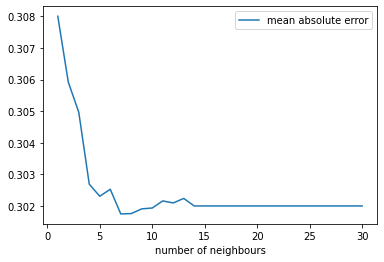

In [363]:
plt.plot(list_KNN, list_mae)
plt.legend(['mean absolute error'])
plt.xlabel('number of neighbours')

Text(0.5, 0, 'number of neighbours')

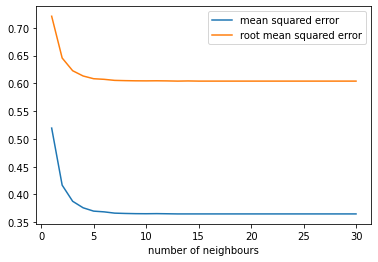

In [254]:
plt.plot(list_KNN, list_mse)
plt.plot(list_KNN, list_rmse)
plt.legend(['mean squared error', 'root mean squared error'])
plt.xlabel('number of neighbours')

In [223]:
max_ = 0
for route_id in df_test.route_id.unique():
    max_ = max(len(df_train.loc[df_train['route_id']==route_id, 'user_id']), max_)

In [224]:
max_

23

In [230]:
print(num_of_all_predictions)

22795


# Surprise library implementation

In [2]:
train_file_name = 'data/train_ds_ds_v7_allhist.csv'#'data/train_ds_ds_v7_single_time_all_hist.csv'
test_file_name = 'data/test_ds_ds_v7_allhist.csv'#'data/test_ds_ds_v7_single_time_all_hist.csv'
df_train_svd = pd.read_csv(train_file_name)
df_test_svd = pd.read_csv(test_file_name)

df_train_svd['diff'] = df_train_svd['user_grade_id'] - df_train_svd['grade_id']
df_test_svd['diff'] = df_test_svd['user_grade_id'] - df_test_svd['grade_id']

In [4]:
df_train_svd.columns

Index(['Unnamed: 0', 'train', 'date', 'route_id', 'user_id', 'grade_id',
       'user_grade_id', 'user_grade_eval_bias', 'route_eval_bias',
       'avg_rs_grade_diff', 'route_perc_proposed', 'user_perc_proposed',
       'route_eligible', 'user_eligible', 'avg_user_grade_id_per_grade',
       'avg_rating_per_route', 'avg_tries_per_route',
       'avg_user_grade_id_per_route', 'avg_climb_type_per_route',
       'avg_user_grade_id_rp_per_grade', 'diff'],
      dtype='object')

In [12]:
train_file_name = 'data/train_ds_ds_v7_single_time_all_hist.csv'
test_file_name = 'data/test_ds_ds_v7_single_time_all_hist.csv'
df_train_svd = pd.read_csv(train_file_name)
df_test_svd = pd.read_csv(test_file_name)

df_train_svd['diff'] = df_train_svd['user_grade_id'] - df_train_svd['grade_id']
df_test_svd['diff'] = df_test_svd['user_grade_id'] - df_test_svd['grade_id']

In [74]:
len(df_train_svd)

188671

In [75]:
len(df_test_svd)

47168

In [26]:
len(df_train_svd.user_id.unique())

3340

In [27]:
len(df_test_svd.user_id.unique())

3326

In [5]:
(sum(df_test_svd['diff']**2)/len(df_test_svd))**0.5

0.4058238763921391

In [66]:
sum(df_test_svd['diff']**2)/len(df_test_svd)

0.14743046132971507

In [96]:
df_test_svd['diff'] = abs(df_test_svd['diff'])
sum(df_test_svd['diff'])/len(df_test_svd)

0.1090320184848985

In [19]:
# A reader is still needed but only the rating_scale param is requiered.
mmin, mmax = -3, 3
reader = Reader(rating_scale=(mmin, mmax))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_train_svd[['user_id','route_id','diff']], reader)

In [20]:
# testset_model_surprise = Dataset.load_from_df(df_test_svd[['user_id','route_id','diff']], reader).build_full_trainset()
trainset_model_surprise = Dataset.load_from_df(df_train_svd[['user_id','route_id','diff']], reader)
# testset = testset_model_surprise.build_testset()
testset = df_test_svd[['user_id','route_id','diff']].values
trainset = trainset_model_surprise.build_full_trainset()

In [71]:
list_lr_bu = [0.1]
list_lr_bi = [0.005]
list_lr_pu = [0.01]
list_lr_qi = [0.01]
list_reg_bu = [0.01]
list_reg_bi = [0.005]
list_reg_pu = [0.5]
list_reg_qi = [0.5]
list_epochs = [100]

for reg_pu in list_reg_pu:
    for reg_qi in list_reg_qi:
        for reg_bu in list_reg_bu:
            for lr_bu in list_lr_bu:
                for lr_bi in list_lr_bi:
                    print('reg_pu: ', reg_pu, ' reg_qi: ', reg_qi, 'reg_bu', reg_bu, ' lr_bu: ', lr_bu, ' lr_bi: ', lr_bi)
                    algo = NMF(n_factors = 50,
                              n_epochs = 20,
                              biased = True,
                              verbose=False,
                              reg_pu = reg_pu,
                              reg_qi = reg_qi,
                              reg_bu = reg_pu,
                              lr_bu = lr_bu,
                              lr_bi = lr_bi,
                              init_low = 0.1)
                    predictions = algo.fit(trainset).test(testset)
                    accuracy.rmse(predictions)
                    accuracy.mse(predictions)
                    accuracy.mae(predictions)

reg_pu:  0.5  reg_qi:  0.5 reg_bu 0.01  lr_bu:  0.1  lr_bi:  0.005
RMSE: 1.0692
MSE: 1.1433
MAE:  0.5858


In [418]:
len(testset)

3995

In [102]:
from surprise import SlopeOne

algo = SlopeOne()
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)
accuracy.mse(predictions)
accuracy.mae(predictions)

RMSE: 0.4339
MSE: 0.1883
MAE:  0.2054


0.20542308263724265

In [41]:
all_users = 0
number_of_users_with_less_mae = 0
users_dic = {}
users_count_dic = {}
for user_id, route_id, diff in testset:
    pred = algo.predict(user_id, route_id, r_ui=diff, verbose=False)
    if user_id in users_dic.keys():
        users_dic[user_id] += abs(np.round(pred[3]) - diff)
        users_count_dic[user_id] += 1
    else:
        users_dic[user_id] = abs(np.round(pred[3]) - diff)
        users_count_dic[user_id] = 1
        all_users += 1
for user_id in users_dic.keys():
    if users_dic[user_id]/users_count_dic[user_id] < 0.139:
        number_of_users_with_less_mae += 1
print(number_of_users_with_less_mae)
print(all_users)

NameError: name 'algo' is not defined

In [124]:
num_tp = 0
num_all = 0
for user_id, route_id, diff in testset:
    pred = algo.predict(user_id, route_id, r_ui=diff, verbose=False)
    if abs(np.round(pred[3]) - diff)==0:
        num_tp += 1
    num_all += 1
print(num_tp/num_all)

0.875


In [27]:
sim_options = {
    'name': 'pearson_baseline', #pearson_baseline msd cosine pearson
     'shrinkage': 10,
      'user_based': False
    }

bsl_options = {'method': 'als',
               'learning_rate': .001,
               'n_epochs': 20,
               'reg_u': 12,
               'reg_i': 2
               }

print('KNN ', sim_options['name'], ' user_based: ', sim_options['user_based'])
for k_neighbours in range(8, 9):
    print('k_neighbours: ', k_neighbours)
    algo_knn_basic = KNNBasic( #KNNBaseline( #KNNBasic(# KNNWithZScore KNNWithMeans 
        k=k_neighbours,
        min_k=1, 
        sim_options=sim_options,
        #bsl_options=bsl_options
    )
    predictions = algo_knn_basic.fit(trainset).test(testset)
    accuracy.rmse(predictions)
    accuracy.mse(predictions)
    accuracy.mae(predictions)

KNN  pearson_baseline  user_based:  False
k_neighbours:  8
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.3905
MSE: 0.1525
MAE:  0.1228


# Reading file with predictions of the model

In [112]:
prediction_SVD_single_time = pd.read_csv('/Users/yustinaivanova/git_projects/CaseRecommender/datasets/te_ds_ds_v7_allhist.txt', sep='\t', names=['user_id', 'route_id', 'diff'])

In [ ]:
prediction_SVD_single_time = pd.read_csv('/Users/yustinaivanova/git_projects/CaseRecommender/datasets/tr_ds_ds_v7_allhist.txt', sep='\t', names=['user_id', 'route_id', 'diff'])

In [113]:
prediction_SVD_single_time.head()

,user_id,route_id,diff
0,30119,1011,0
1,30119,1189,0
2,30119,1020,0
3,30119,1023,0
4,30119,1048,0


In [114]:
len(prediction_SVD_single_time)

48472

In [115]:
prediction_SVD_single_time[prediction_SVD_single_time.user_id==49]

,user_id,route_id,diff


In [116]:
t = pd.read_csv('/Users/yustinaivanova/git_projects/CaseRecommender/computation_results/res_gsvd_2abb44e6-923d-11eb-add4-38f9d3579a46ds_ds_v7_allhist.txt', sep='\t', names=['user_id', 'route_id', 'diff'])

In [122]:
t = pd.read_csv('/Users/yustinaivanova/git_projects/CaseRecommender/datasets/tr_ds_ds_v7_single_time_all_hist.txt', sep='\t', names=['user_id', 'route_id', 'diff'])

In [123]:
len(t)

188671

In [118]:
t['real_diff'] = prediction_SVD_single_time['diff']

In [119]:
t.head()

,user_id,route_id,diff,real_diff
0,33,86759,-0.075725,0
1,33,87541,-0.119998,0
2,33,70677,-0.061274,0
3,33,71473,-0.064941,0
4,33,87984,-0.068642,0


In [120]:
all_users = 0
number_of_users_with_less_mae = 0
users_dic = {}
users_count_dic = {}
for ind in t.index:
    user_id, route_id, diff, real_diff = t.loc[ind, :]
    if user_id in users_dic.keys():
        users_dic[user_id] += (np.round(real_diff) - diff)**2
        users_count_dic[user_id] += 1
    else:
        users_dic[user_id] = (np.round(real_diff) - diff)**2
        users_count_dic[user_id] = 1
        all_users += 1
avg_rmse = 0
for user_id in users_dic.keys():
    avg_rmse += (users_dic[user_id]/users_count_dic[user_id])**0.5
    if users_dic[user_id]/users_count_dic[user_id] < 0.406:
        number_of_users_with_less_mae += 1
print('avg_rmse_per_user: ', avg_rmse/all_users)
print(number_of_users_with_less_mae)
print(all_users)

avg_rmse_per_user:  0.33031519169475637
2874
3326


In [121]:
std = 0
for user_id in users_dic.keys():
    std += ((users_dic[user_id]/users_count_dic[user_id])**0.5 - avg_rmse/all_users)**2
std = (std/all_users)**0.5
print('std: ', std)

std:  0.2802612226307025


In [28]:
all_users = 0
number_of_users_with_less_mae = 0
users_dic = {}
users_count_dic = {}
for user_id, route_id, diff in testset:
    pred = algo_knn_basic.predict(user_id, route_id, r_ui=diff, verbose=False)
    if user_id in users_dic.keys():
        users_dic[user_id] += (np.round(pred[3]) - diff)**2
        users_count_dic[user_id] += 1
    else:
        users_dic[user_id] = (np.round(pred[3]) - diff)**2
        users_count_dic[user_id] = 1
        all_users += 1
avg_rmse = 0
for user_id in users_dic.keys():
    avg_rmse += (users_dic[user_id]/users_count_dic[user_id])**0.5
    if users_dic[user_id]/users_count_dic[user_id] < 0.384:
        number_of_users_with_less_mae += 1
print('avg_rmse_per_user: ', avg_rmse/all_users)
print(number_of_users_with_less_mae)
print(all_users)

avg_rmse_per_user:  0.255878034462318
1555
1772


In [29]:
std = 0
for user_id in users_dic.keys():
    std += ((users_dic[user_id]/users_count_dic[user_id])**0.5 - avg_rmse/all_users)**2
std = (std/all_users)**0.5
print('std: ', std)

std:  0.32813489875516844


In [142]:
num_tp = 0
num_all = 0
for user_id, route_id, diff in testset:
    pred = algo_knn_basic.predict(user_id, route_id, r_ui=diff, verbose=False)
    if abs(np.round(pred[3]) - diff)==0:
        num_tp += 1
    num_all += 1
print(num_tp/num_all)

0.901902129064202


In [37]:
len(testset)

47168

In [103]:
list_lr = [3, 0.5, 0.1, 0.05, 0.005, 0.001, 0.0001]
list_reg = [0.75, 0.5, 0.1, 0.05, 0.001, 0.0001]
list_lr_bu = [0.01]
list_lr_bi = [0.1]
list_lr_pu = [0.001]
list_lr_qi = [0.5]
list_reg_bu = [0.1]
list_reg_bi = [0.5]
list_reg_pu = [0.1]
list_reg_qi = [0.5]
list_epochs = [20]
for epochs_ in list_epochs:
    for lr_bu_ in list_lr_bu:
        for lr_bi_ in list_lr_bi:
            for lr_pu_ in list_lr_pu:
                for lr_qi_ in list_lr_qi:
                    for reg_bu_ in list_reg_bu:
                        for reg_bi_ in list_reg_bi:
                            for reg_pu_ in list_reg_pu:
                                for reg_qi_ in list_reg_qi:
                                    algo = SVD(n_factors=100, # The number of factors. Default is 100.
                                               n_epochs=100, # The number of iteration of the SGD procedure. Default is 20.
                                               biased = True, # Whether to use baselines (or biases). See note above. Default is True.
                                               init_mean =0, # The mean of the normal distribution for factor vectors initialization. Default is 0.
                                               init_std_dev=0.1, # The standard deviation of the normal distribution for factor vectors initialization.
                                                                   # Default is 0.1.
                                               lr_all=0.005, # The learning rate for all parameters. Default is 0.005.
                                               reg_all=0.1, # The regularization term for all parameters. Default is 0.02.
                                               lr_bu=lr_bu_, # The learning rate for 𝑏𝑢.
                                               lr_bi=lr_bi_, #
                                               lr_pu=lr_pu_, #
                                               lr_qi=lr_qi_, #
                                               reg_bu=reg_bu_, #
                                               reg_bi=reg_bi_, #
                                               reg_pu=reg_pu_, #
                                               reg_qi=reg_qi_ #
                                              )
                                    algo.fit(trainset)
                                    # Evaluation
                                    predictions = algo.test(testset)
                                    print(' epochs: ', epochs_, ' lr_bu: ', lr_bu_, ' lr_bi: ', lr_bi_, ' lr_pu: ', lr_pu_, ' lr_qi: ', lr_qi_)
                                    print('reg_bu: ', reg_bu_, ' reg_bi: ', reg_bi_, ' reg_pu: ', reg_pu_, ' reg_qi: ', reg_qi_)
                                    print(f'MAE: {accuracy.mae(predictions, verbose=False):.3f}')
                                    print(f'MSE : {accuracy.mse(predictions, verbose=False):.3f}')
                                    print(f'RMSE: {accuracy.rmse(predictions, verbose=False):.3f}')

 epochs:  20  lr_bu:  0.01  lr_bi:  0.1  lr_pu:  0.001  lr_qi:  0.5
reg_bu:  0.1  reg_bi:  0.5  reg_pu:  0.1  reg_qi:  0.5
MAE: 0.170
MSE : 0.142
RMSE: 0.377


In [ ]:
#trainset
#testset

In [32]:
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_train_svd[['user_id','route_id','diff']], reader)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4219  0.4199  0.4171  0.4241  0.4223  0.4211  0.0024  
MAE (testset)     0.1822  0.1818  0.1813  0.1842  0.1829  0.1825  0.0010  
Fit time          0.53    0.55    0.53    0.52    0.58    0.54    0.02    
Test time         0.32    0.31    0.29    0.29    0.29    0.30    0.01    


{'test_rmse': array([0.42186076, 0.41988021, 0.41714933, 0.42407543, 0.42229512]),
 'test_mae': array([0.18223528, 0.18179274, 0.18125258, 0.18424824, 0.18290278]),
 'fit_time': (0.5266039371490479,
  0.5486421585083008,
  0.5268092155456543,
  0.5237429141998291,
  0.575430154800415),
 'test_time': (0.3214900493621826,
  0.30975914001464844,
  0.2918400764465332,
  0.28946399688720703,
  0.2872169017791748)}

In [ ]:

param_grid = {'n_epochs': [20, 30, 50],
              'lr_bu': [0.5, 0.1, 0.05, 0.005, 0.001, 0.0001],
              'lr_bi': [0.5, 0.1, 0.05, 0.005, 0.001, 0.0001],
              'lr_pu': [0.5, 0.1, 0.05, 0.005, 0.001, 0.0001],
              'lr_qi': [0.5, 0.1, 0.05, 0.005, 0.001, 0.0001],
              'reg_bu': [0.5, 0.1, 0.05, 0.005, 0.001, 0.0001],
              'reg_bi': [0.5, 0.1, 0.05, 0.005, 0.001, 0.0001],
              'reg_pu': [0.5, 0.1, 0.05, 0.005, 0.001, 0.0001],
              'reg_qi': [0.5, 0.1, 0.05, 0.005, 0.001, 0.0001],
             }
                                               
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

In [105]:
all_users = 0
number_of_users_with_less_mae = 0
users_dic = {}
users_count_dic = {}
for user_id, route_id, diff in testset:
    pred = algo.predict(user_id, route_id, r_ui=diff, verbose=False)
    if user_id in users_dic.keys():
        users_dic[user_id] += (np.round(pred[3]) - diff)**2
        users_count_dic[user_id] += 1
    else:
        users_dic[user_id] = (np.round(pred[3]) - diff)**2
        users_count_dic[user_id] = 1
        all_users += 1
avg_rmse = 0
for user_id in users_dic.keys():
    avg_rmse += (users_dic[user_id]/users_count_dic[user_id])**0.5
    if users_dic[user_id]/users_count_dic[user_id] < 0.406:
        number_of_users_with_less_mae += 1
print('avg_rmse_per_user: ', avg_rmse/all_users)
print(number_of_users_with_less_mae)
print(all_users)

avg_rmse_per_user:  0.24724496875432986
2955
3326


In [106]:
std = 0
for user_id in users_dic.keys():
    std += ((users_dic[user_id]/users_count_dic[user_id])**0.5 - avg_rmse/all_users)**2
std = (std/all_users)**0.5
print('std: ', std)

std:  0.30824383185006293


In [93]:
num_tp = 0
num_all = 0
for user_id, route_id, diff in testset:
    pred = algo.predict(user_id, route_id, r_ui=diff, verbose=False)
    if abs(np.round(pred[3]) - diff)==0:
        num_tp += 1
    num_all += 1
print(num_tp/num_all)

0.9139882971506106


In [12]:
from statsmodels.stats.proportion import proportions_ztest

# Null hypothesis: population proportion is equal to hypothesized proportion
# Alternative hypothesis: population proportion is not equal to hypothesized proportion (two -tailed)

number_of_correctly_found = 537
overall_number = 600
null_hypothesis = 0.90
significance = 0.05
print("sample_success ", number_of_correctly_found)
print("sample_size ", overall_number)
stat, p_value = proportions_ztest(count=number_of_correctly_found, nobs=overall_number, value=null_hypothesis,
                                  alternative='smaller')
print("Proportion ztest", round(stat, 3), round(p_value, 3))
if p_value > significance:
    print ("Fail to reject the null hypothesis - we have nothing else to say")
    print("population proportion is equal to hypothesized proportion")
else:
    print ("Reject the null hypothesis - suggest the alternative hypothesis is true")
    print("population proportion is not equal to hypothesized proportion (two -tailed)")

sample_success  537
sample_size  600
Proportion ztest -0.4 0.345
Fail to reject the null hypothesis - we have nothing else to say
population proportion is equal to hypothesized proportion


In [420]:
print(len(testset))

3995


In [265]:
bsl_options_als = {'method': 'als',
               'n_epochs': 1000
               }
sim_options = {'name': 'pearson_baseline', 'user_based': False}
algo = KNNBasic(bsl_options=bsl_options_als, sim_options=sim_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)
accuracy.mse(predictions)
accuracy.mae(predictions)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.6158
MSE: 0.3792
MAE:  0.2949


0.29487782788356454

In [ ]:
from surprise import SVDpp
algo_ = SVDpp(n_factors=50, # The number of factors. Default is 100.
               n_epochs=30, # The number of iteration of the SGD procedure. Default is 20.
               init_mean =0, # The mean of the normal distribution for factor vectors initialization. Default is 0.
               init_std_dev=0.1, # The standard deviation of the normal distribution for factor vectors initialization.
                                   # Default is 0.1.
               lr_all=0.005, # The learning rate for all parameters. Default is 0.005.
               reg_all=0.1, # The regularization term for all parameters. Default is 0.02.
               lr_bu=lr_bu_, # The learning rate for 𝑏𝑢.
               lr_bi=lr_bi_, #
               lr_pu=lr_pu_, #
               lr_qi=lr_qi_, #
               reg_bu=reg_bu_, #
               reg_bi=reg_bi_, #
               reg_pu=reg_pu_, #
               reg_qi=reg_qi_ )#)
algo_.fit(trainset)
# Evaluation
predictions = algo_.test(testset)

print(f'MAE: {accuracy.mae(predictions, verbose=False):.3f}')
print(f'MSE : {accuracy.mse(predictions, verbose=False):.3f}')
print(f'RMSE: {accuracy.rmse(predictions, verbose=False):.3f}')

In [75]:
from surprise import CoClustering
algo_ = CoClustering(n_cltr_u=1000, n_cltr_i=1000, n_epochs=30)
algo_.fit(trainset)
# Evaluation
predictions = algo_.test(testset)

print(f'MAE: {accuracy.mae(predictions, verbose=False):.3f}')
print(f'MSE : {accuracy.mse(predictions, verbose=False):.3f}')
print(f'RMSE: {accuracy.rmse(predictions, verbose=False):.3f}')

KeyboardInterrupt: 

In [42]:
from scipy.stats import pearsonr

user1 = [7,6,7,4,5,4]
user2 = [6,7,4,3,4]
user3 = [0,3,3,1,1,0]
user4 = [1,2,2,3,3,4]
user5 = [1,0,1,2,3,3]


In [43]:
sum(user1)/len(user1)

5.5

In [44]:
sum(user2)/len(user2)

4.8

In [33]:
user1 = [6,7,4,5]
user2 = [7,0,4,3]
user3 = [3,3,1,1]
user4 = [2,2,3,3]
user5 = [0,1,2,3]
r, pvalue = pearsonr(user3, user4)
print(r)

-1.0


In [34]:
from scipy.spatial import distance
# cosin distance = 1 - angle
print(distance.cosine(user1, user3))
print(distance.cosine(user2, user3))
print(distance.cosine(user4, user3))
print(distance.cosine(user5, user3))

0.04381711253248499
0.272174657125949
0.21064778262367367
0.5219085562662426


In [21]:
(sum(user1) + sum(user2) + sum(user3) + sum(user4) + sum(user5))/26

3.4615384615384617

In [22]:
#average_mu = 3.46
bu = sum(user3)/4

In [23]:
print(bu)

2.0


In [25]:
bi = (7+6+1+1)/4
print(bi)

3.75


In [54]:
train_file_name = 'data/train_ds_ds_v7_allhist.csv'#'data/train_ds_ds_v7_single_time_all_hist.csv'
test_file_name = 'data/test_ds_ds_v7_allhist.csv'#'data/test_ds_ds_v7_single_time_all_hist.csv'
df_train_svd = pd.read_csv(train_file_name)
df_test_svd = pd.read_csv(test_file_name)

df_train_svd['diff'] = df_train_svd['user_grade_id'] - df_train_svd['grade_id']
df_test_svd['diff'] = df_test_svd['user_grade_id'] - df_test_svd['grade_id']

tr = df_train_svd[['user_id','route_id','diff']]
te = df_test_svd[['user_id','route_id','diff']]

In [55]:
df_train_svd.head()

,Unnamed: 0,train,date,route_id,user_id,grade_id,user_grade_id,user_grade_eval_bias,route_eval_bias,avg_rs_grade_diff,...,user_perc_proposed,route_eligible,user_eligible,avg_user_grade_id_per_grade,avg_rating_per_route,avg_tries_per_route,avg_user_grade_id_per_route,avg_climb_type_per_route,avg_user_grade_id_rp_per_grade,diff
0,0,1,2016-06-01 00:00:00,1517,31819,14,17,0.25,0.50,0.15,...,0.27,0,0,14,2.67,1.33,15,2.50,14,3
1,1,1,2016-06-01 00:00:00,1519,31819,15,15,0.16,0.00,0.00,...,0.27,0,0,15,4.00,2.00,15,2.00,15,0
2,2,1,2016-09-21 00:00:00,1753,30380,14,14,0.00,-0.13,0.03,...,0.03,0,0,14,2.25,1.50,14,2.50,14,0
3,3,1,2016-09-25 00:00:00,1201,9591,18,18,0.00,0.00,-0.03,...,0.10,0,0,18,1.50,1.25,18,2.75,18,0
4,4,1,2016-09-29 00:00:00,981,4716,14,14,-0.12,0.00,0.02,...,0.07,0,0,14,1.50,1.50,14,3.00,14,0


In [51]:
tr.to_csv(r'datasets/tr.txt', header=None, index=None, sep='\t', mode='a')
te.to_csv(r'datasets/te.txt', header=None, index=None, sep='\t', mode='a')

In [52]:
# Cross Validation
# recommender = MatrixFactorization()

# CrossValidation(input_file=db, recommender=recommender, dir_folds=folds_path, header=1, k_folds=5).compute()

# # Simple
# MatrixFactorization(tr, te).compute()
# SVDPlusPlus(tr, te).compute()
tr = 'datasets/tr.txt'
te = 'datasets/te.txt'
SVDPlusPlus(tr, te, factors = 20).compute()

[Case Recommender: Rating Prediction > SVDPlusPlus]

train data:: 3340 users and 34210 items (376038 interactions) | sparsity:: 99.67%
test data:: 3328 users and 21630 items (95640 interactions) | sparsity:: 99.87%

training_time:: 1516.305958 sec
prediction_time:: 1.952241 sec


Eval:: MAE: 0.198898 RMSE: 0.358651 


In [53]:
SVDPlusPlus(tr, te, factors = 20,
            learn_rate=0.005,
            epochs=100,
            delta=0.015,
            init_mean=0,
            init_stdev=0.1,
            bias_learn_rate=0.005,
            delta_bias=0.002,
            stop_criteria=0.009,
            update_delta=False).compute()

[Case Recommender: Rating Prediction > SVDPlusPlus]

train data:: 3340 users and 34210 items (376038 interactions) | sparsity:: 99.67%
test data:: 3328 users and 21630 items (95640 interactions) | sparsity:: 99.87%



KeyboardInterrupt: 